In [1]:
import pandas as pd
import re
import string
import os
import torch
import numpy as np
import tqdm
from transformers import *

I0128 18:50:40.863723  8744 file_utils.py:35] PyTorch version 1.3.1 available.
I0128 18:50:44.803600  8744 file_utils.py:48] TensorFlow version 2.0.0 available.


In [2]:
path_to_dataset = 'C:\\Users\\bokhy\\Python\\pytorch\\pytorch\\data\\nlp-getting-started\\'

In [3]:
train = pd.read_csv(os.path.join(path_to_dataset, 'train.csv'))
test = pd.read_csv(os.path.join(path_to_dataset, 'test.csv'))

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

I0127 22:15:40.058504 24624 file_utils.py:362] https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt not found in cache or force_download set to True, downloading to C:\Users\bokhy\AppData\Local\Temp\tmpr9i9gos6
I0127 22:15:40.768607 24624 file_utils.py:377] copying C:\Users\bokhy\AppData\Local\Temp\tmpr9i9gos6 to cache at C:\Users\bokhy\.cache\torch\transformers\9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0127 22:15:40.771598 24624 file_utils.py:381] creating metadata file for C:\Users\bokhy\.cache\torch\transformers\9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0127 22:15:40.773594 24624 file_utils.py:390] removing temp file C:\Users\bokhy\AppData\Local\Temp\tmpr9i9gos6
I0127 22:15:40.774590 24624 tokenization_utils.py:398] loading file https://s3.amazonaws.com/models.huggingface.co/bert/

In [6]:
class Model(torch.nn.Module):
    
    def __init__(self, ):
        
        super(Model, self).__init__()
        self.base_model = BertModel.from_pretrained('bert-base-uncased') # use pre-trained BERT model by HuggingFace
        self.fc1 = torch.nn.Linear(768, 1) # simple logistic regression above the bert model
        
    def forward(self, ids, masks):
        
        x = self.base_model(ids, attention_mask=masks)[1]
        x = self.fc1(x)
        return x

In [7]:
model = Model()

I0127 22:15:44.412093 24624 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at C:\Users\bokhy\.cache\torch\transformers\4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I0127 22:15:44.414086 24624 configuration_utils.py:199] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": 

In [8]:
# Set-up GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [9]:
def bert_encode(text, max_len=128):
    
    text = tokenizer.tokenize(text)
    text = text[:max_len-2]
    input_sequence = ["[CLS]"] + text + ["[SEP]"]
    tokens = tokenizer.convert_tokens_to_ids(input_sequence)
    tokens += [0] * (max_len - len(input_sequence))
    pad_masks = [1] * len(input_sequence) + [0] * (max_len - len(input_sequence))

    return tokens, pad_masks

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9] \n', '', text)
    return text

In [11]:
# Use first 6000 for training, rest for validation

In [12]:
train_text = train.text[:6000]
val_text = train.text[6000:]

In [13]:
train_text = train_text.apply(clean_text)
val_text = val_text.apply(clean_text)

In [14]:
# Train token
train_tokens = []
train_pad_masks = []
for text in train_text:
    tokens, masks = bert_encode(text)
    train_tokens.append(tokens)
    train_pad_masks.append(masks)
    
train_tokens = np.array(train_tokens)
train_pad_masks = np.array(train_pad_masks)

In [15]:
# Validation token
val_tokens = []
val_pad_masks = []
for text in val_text:
    tokens, masks = bert_encode(text)
    val_tokens.append(tokens)
    val_pad_masks.append(masks)
    
val_tokens = np.array(val_tokens)
val_pad_masks = np.array(val_pad_masks)

In [16]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, train_tokens, train_pad_masks, targets):
        
        super(Dataset, self).__init__()
        self.train_tokens = train_tokens
        self.train_pad_masks = train_pad_masks
        self.targets = targets
        
    def __getitem__(self, index):
        
        tokens = self.train_tokens[index]
        masks = self.train_pad_masks[index]
        target = self.targets[index]
        
        return (tokens, masks), target
    
    def __len__(self,):
        
        return len(self.train_tokens)

In [17]:
# Accuracy Metric
def accuracy(y_actual, y_pred):
    y_ = y_pred > 0
    return np.sum(y_actual == y_).astype('int') / y_actual.shape[0]

In [18]:
train_dataset = Dataset(
                    train_tokens=train_tokens,
                    train_pad_masks=train_pad_masks,
                    targets=train.target[:6000]
)

In [19]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=6, shuffle=True)

In [20]:
val_dataset = Dataset(
                    train_tokens=val_tokens,
                    train_pad_masks=val_pad_masks,
                    targets=train.target[6000:].reset_index(drop=True)
)

In [21]:
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=3, shuffle=False)

In [22]:
criterion = torch.nn.BCEWithLogitsLoss()

In [23]:
# Optimizaer: Use ADAM with Learning Rate 0.00001
opt = torch.optim.Adam(model.parameters(), lr=0.00001)

In [24]:
# Train for 3 Epoch for Training/Validation set
EPOCHS = 3
model.train()
y_preds = []

for epoch in range(EPOCHS):
        for i, ((tokens, masks), target) in enumerate(train_dataloader):

            y_pred = model(                            # This is the forward pass (just put tokens and maskds inside model)
                        tokens.long().to(device), 
                        masks.long().to(device)
                    )
            loss = criterion(y_pred, target[:, None].float().to(device))
            opt.zero_grad()
            loss.backward()
            opt.step()
            print('\rEpoch: %d/%d, %f%% train_loss: %0.2f'% (epoch+1, EPOCHS, i/len(train_dataloader)*100, loss.item()), end='') 
        else: 
            avg_acc = 0
            with torch.no_grad(): # no trainig for valid set ==> no need gradient (save memory)
                model.eval() # Turn-off drop-out to make it as inference mode
                for i, ((tokens, masks), target) in enumerate(val_dataloader):

                    y_pred = model(
                                tokens.long().to(device), 
                                masks.long().to(device), 
                            )
                    valid_loss = criterion(y_pred,  target[:, None].float().to(device))
                    acc = accuracy(target.cpu().numpy(), y_pred.detach().cpu().numpy().squeeze())
                    avg_acc += acc
            
            model.train()
               
            print('\r%0.2f%% valid_loss: %0.2f, accuracy %0.2f'% (i/len(val_dataloader)*100, valid_loss.item(), acc), end='')
            print('\nAverage accuracy: ', avg_acc / len(val_dataloader))

99.81% valid_loss: 0.03, accuracy 1.003
Average accuracy:  0.8314745972738545
99.81% valid_loss: 0.01, accuracy 1.007
Average accuracy:  0.829615861214375
99.81% valid_loss: 0.01, accuracy 1.005
Average accuracy:  0.8389095415117728


In [24]:
%matplotlib inline
%config InLineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

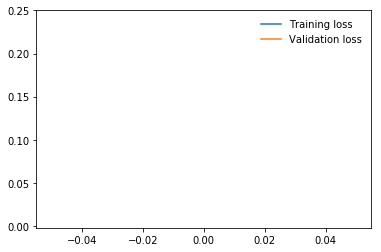

In [27]:
plt.plot(loss.detach().cpu().numpy(), label = "Training loss")
plt.plot(valid_loss.detach().cpu().numpy(), label = "Validation loss")
plt.legend(frameon = False)

In [25]:
# Define on TestDataset
class TestDataset(torch.utils.data.Dataset):
    
    def __init__(self, test_tokens, test_pad_masks):
        
        super(TestDataset, self).__init__()
        self.test_tokens = test_tokens
        self.test_pad_masks = test_pad_masks
        
    def __getitem__(self, index):
        
        tokens = self.test_tokens[index]
        masks = self.test_pad_masks[index]
        
        return (tokens, masks)
    
    def __len__(self,):
        
        return len(self.test_tokens)

In [26]:
test_tokens = []
test_pad_masks = []
for text in test.text:
    tokens, masks = bert_encode(text)
    test_tokens.append(tokens)
    test_pad_masks.append(masks)
    
test_tokens = np.array(test_tokens)
test_pad_masks = np.array(test_pad_masks)

In [27]:
test_dataset = TestDataset(
    test_tokens=test_tokens,
    test_pad_masks=test_pad_masks
)

In [49]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=3, shuffle=False)

In [50]:
model.eval() # Turn-off drop-out to prevent overfitting
y_preds = []
for (tokens, masks) in test_dataloader:

    y_pred = model(
                tokens.long().to(device), 
                masks.long().to(device), 
            )
    y_preds += y_pred.detach().cpu().numpy().squeeze().tolist()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.04 GiB already allocated; 10.47 MiB free; 5.80 MiB cached)

In [33]:
submission_df = pd.read_csv(os.path.join(path_to_dataset, 'sample_submission.csv'))

In [34]:
submission_df['target'] = (np.array(y_preds) > 0).astype('int')

In [35]:
submission_df.target.value_counts()

0    1971
1    1292
Name: target, dtype: int64

In [36]:
submission_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [37]:
submission_df.to_csv('submission.csv', index=False)